# The Lorenz Chaotic Attractor

This example show how a classical chaotic dynamical system (the Lorenz "butterfly"
attractor) can be implemented in a neural population. The dynamical equations for this
attractor are:
$$
\begin{align}
    \dot{x}_0 &= \sigma(x_1 - x_0) \\
    \dot{x}_1 &= x_0(\rho - x_2) - x_1 \\
    \dot{x}_2 &= x_0 x_1 - \beta x_2
\end{align}
$$

Since $x_2$ is approximately centered around $\rho$, and because NEF ensembles are
typically optimized to represent values within a pre-defined radius of the origin, we
substitute $x'_2 = x_2 - \rho$, yielding these equations:
$$
\begin{align}
    \dot{x}_0 &= \sigma(x_1 - x_0) \\
    \dot{x}_1 &= -x_0 x'_2 - x_1 \\
    \dot{x}'_2 &= x_0 x_1 - \beta(x'_2 + \rho) - \rho
\end{align}
$$

As with the previous oscillator examples, an exponential synapse is being used to
implement these dynamics, meaning that the neural feedback matrix is:
$$
\mathbf{A}' = \tau\mathbf{A} + \mathbf{I}
$$

Because the Lorenz attractor has no input signal $u$, this in turn means that the neural
feedback function can be computed as:
$$
\begin{align}
    f_{fdbk}(x) &= \mathbf{A}' x \\
    &= \tau\mathbf{A}x + x \\
    &= \tau\dot{x} + x \\
    &= \begin{bmatrix}
           \tau\dot{x}_0 + x_0 \\
           \tau\dot{x}_1 + x_1 \\
           \tau\dot{x}'_2 + x_2
       \end{bmatrix}
\end{align}
$$

For more information, see [“Chris Eliasmith. A unified approach to building and
controlling spiking attractor networks. Neural computation, 7(6):1276-1314,
2005.”](http://compneuro.uwaterloo.ca/publications/eliasmith2005b.html)

## Step 1: Set up the Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML

import nengo

from mpl_toolkits.mplot3d import Axes3D

from anim_utils import make_anim_chaotic

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run. This name
corresponds with the name in your `fpga_config` file. Recall that in the `fpga_config`
file, device names are identified by the square brackets (e.g., **[de1]** or
**[pynq]**). The names defined in your configuration file might differ from the example
below. Here, the device **de1** is being used.

In [2]:
board = "de1"  # Change this to your desired device name

## Step 3: Create the FPGA Ensemble

Create a remote FPGA neural ensemble (`FpgaPesEnsembleNetwork`) using the board defined
above, 2000 neurons, 3 dimensions, and with no learning rate. We will also specify the
recurrent connection here.

In [3]:
tau = 0.1  # Synaptic time constant

# Lorenz attractor parameters
sigma = 10
beta = 8.0 / 3.0
rho = 28

with nengo.Network(label="Lorenz Attractor") as model:
    # Remote FPGA neural ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,  # The board to use (from above)
        n_neurons=2000,  # The number of neurons to use in the ensemble
        dimensions=3,  # 3 dimensions
        learning_rate=0,  # No learning for this example
        feedback=1,  # Activate the recurrent connection
    )

    # The representational space of the Lorenz attractor is pretty big,
    # so adjust the radius of the neural ensemble appropriately.
    fpga_ens.ensemble.radius = 50

    # Setting `feedback=1` creates a `feedback` connection object
    # with the identity transform. To implement the oscillator, it
    # is necessary to set the transform on the feedback connection
    # using .transform.
    fpga_ens.feedback.synapse = tau  # `nengo.LowPass(tau)`

    # Define the feedback function
    def func_fdbk(x):
        # These are the three variables represented by the ensemble
        x0, x1, x2 = x

        dx0 = sigma * (x1 - x0)
        dx1 = -x0 * x2 - x1
        dx2 = x0 * x1 - beta * (x2 + rho) - rho

        return [tau * dx0 + x0, tau * dx1 + x1, tau * dx2 + x2]

    # Assign the feedback function to the feedback connection
    fpga_ens.feedback.function = func_fdbk

Specified FPGA configuration 'de1' not found.


## Step 4: Add Probes to Collect Data

In [4]:
with model:
    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 5: Run the Model

In [5]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(20)

Building network with dummy (non-FPGA) ensemble.


## Step 8: Plot the Results

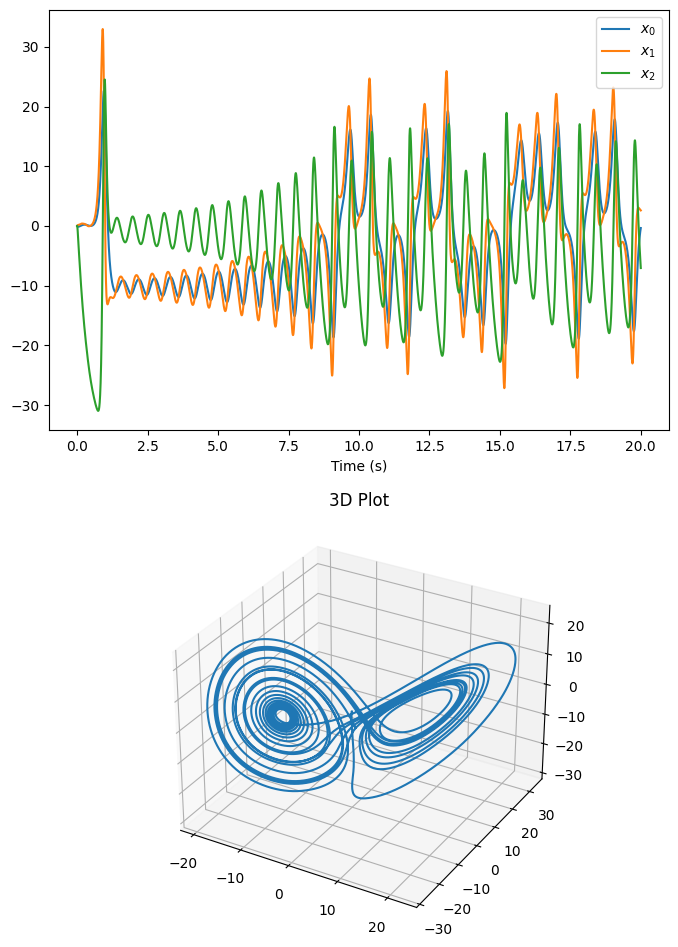

In [6]:
def plot_results():
    plt.figure(figsize=(8, 12))
    plt.subplot(211)
    plt.plot(sim.trange(), sim.data[output_p])
    plt.legend(["$x_0$", "$x_1$", "$x_2$"], loc="upper right")
    plt.xlabel("Time (s)")

    # Make 3D plot
    ax = plt.subplot(212, projection=Axes3D.name)
    ax.plot(*sim.data[output_p].T)
    ax.set_title("3D Plot")

    plt.show()


plot_results()

The plots above show the decoded output of the oscillator exhibiting the dynamics of a
Lorenz "butterfly" attractor. The 3D plot illustrates why this attractor is called a
"butterfly" attractor.

While a static plots are informative, an animated figure can be used to show how the
Lorenz attractor evolves over time. It may take a moment to generate the animation.

In [7]:
def make_anim():
    _, _, anim = make_anim_chaotic(
        sim.data[output_p][:, 0],
        sim.data[output_p][:, 1],
        sim.data[output_p][:, 2],
        ms_per_frame=20,
    )
    return anim


HTML(make_anim().to_html5_video())

## Step 9: Spiking Neurons

The plots above show the output of the Lorenz attractor network implemented with
non-spiking rectified linear neurons. The network can also be simulated using spiking
neurons to illustrate the similarities and differences between a spiking and a
non-spiking network.

Below, we configure the FPGA neural ensemble to use spiking neurons, run the simulation,
and plot the results.

Building network with dummy (non-FPGA) ensemble.


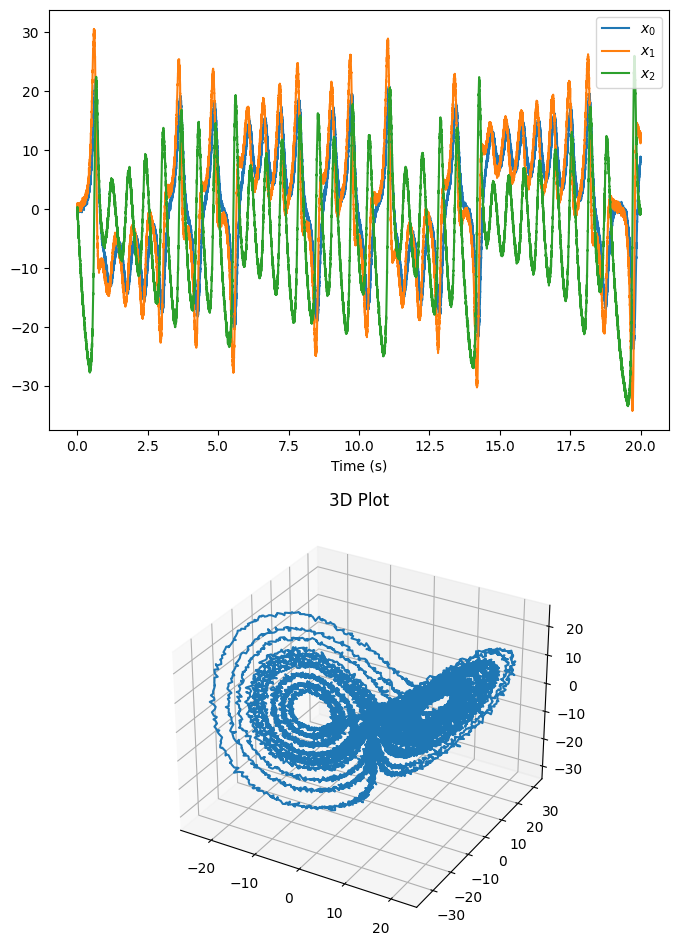

In [8]:
with model:
    fpga_ens.ensemble.neuron_type = nengo.SpikingRectifiedLinear()

with nengo_fpga.Simulator(model) as sim:
    sim.run(20)
plot_results()

In [9]:
HTML(make_anim().to_html5_video())

The plots above show that with spiking neurons, the output of the network is,
expectedly, more noisy (less precise) than the results of the non-spiking network.
However, despite this, the chaotic attractor network in its current configuration is
stable, and exhibits the expected behaviour of the Lorenz attractor.

It should be noted that the output of the spiking Lorenz attractor network differs from
that of the non-spiking network because of two factors. First, every time the Nengo
simulator is created, the network parameters are regenerated (randomized). Second,
because the dynamics of the Lorenz attractor are extremely sensitive to the initial
conditions of the network (which is what makes it chaotic), even if the spiking and
non-spiking networks were generated with the same parameters, the additional noise
introduced by the spikes cause the spiking output to diverge from the trajectory of the
non-spiking network.

## Step 10: Experiment!

Try playing around with the number of neurons in the FPGA ensemble as well as the
synaptic time constant (`tau`) to see how it effects performance (e.g., observe how
changing these numbers affect the stability of the oscillator)! Additionally, modify the
parameters of the Lorenz attractor to see what effect it has on the shape of it. Be sure
to run the simulation multiple times and observe if you can see any identical patterns
(because the attractor is chaotic, every run should be different).

Explore the deterministic (yet chaotic) nature of the Lorenz attractor network, by
constructing the `FpgaPesEnsembleNetwork` with the `seed` parameter, and re-running this
notebook. You should observe because the Lorenz attractor is deterministic, with a
pre-set seed, every run of the notebook will produce identical results. However, because
the attractor is chaotic (very sensitive to the recurrent activity in the network), the
additional noise introduced by the spikes cause it to follow a different trajectory from
the non-spiking network.